# Apprentissage couverture par ML sur la cohérence

## Entraînement du modèle

In [78]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'capsat'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import yaml

from sqlalchemy import create_engine, text
from sqlalchemy.event import listen

import numpy as np
import pandas as pd
import math
from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from joblib import load

from capsat.dbutils import load_spatialite, load_stat_aggregates
from capsat.profile import get_parcel_profile

In [79]:
parameters_file = os.path.join('..', 'etc', 'parameters.yml')
with open(parameters_file, 'r') as f:
    params = yaml.safe_load(f)
lpis_database = params['parameters']['lpis_database']
lpis_table = params['parameters']['lpis_table']
lpis_id = params['parameters']['lpis_id']
models_path = params['parameters']['models_path']
ndvi_cover_threshold = params['parameters']['ndvi_cover_threshold']
ndvi_bare_threshold = params['parameters']['ndvi_bare_threshold']

engine = create_engine(f"sqlite:///{lpis_database}")
listen(engine, 'connect', load_spatialite)
listen(engine, 'connect', load_stat_aggregates)

seasons = ['autumn', 'winter', 'spring', 'summer']

In [80]:
code = 'MPC'
columns_ia = ['coh', 'd_coh', 'coh_min', 'coh_max', 'coh_delta']
columns_ia.extend(seasons)

In [81]:
pipe = load(os.path.join(models_path, f"{code}_pipe.joblib"))

## Visualisation du résultat

In [82]:
def entropy(df):
    win = df['coh'].rolling(36, min_periods=2, center=True)
    d_win = df['d_coh'].rolling(36, min_periods=2, win_type="triang", center=True)
    return ((win.max() - win.min()) * d_win.sum()).round(6)


def get_cover_intervals(df, column='cover'):
    cover_intervals = list()
    cover = False
    start = end = None
    for index, row in df.iterrows():
        if not cover and row[column]:
            start = index
            cover = True
        if cover and not row[column]:
            end = index - pd.DateOffset(days=1)
            cover = False
            iv = pd.Interval(start, end, closed='both')
            cover_intervals.append(iv)
            start = end = None
    if start and not end:
        iv = pd.Interval(start, index, closed='both')
        cover_intervals.append(iv)
    return cover_intervals

In [83]:
sql = text(f"""
    SELECT 
        l.id, 
        l.code_cultu, 
        l.culture_d1_2018, 
        l.culture_d2_2018,
        cc.sowing_start, cc.sowing_end, cc.harvest_start, cc.harvest_end
    FROM {lpis_table} l
    JOIN crop_code cc ON cc.code = l.code_cultu
    WHERE l.code_cultu = :code
    ORDER BY random()
    LIMIT 1
""")
with engine.connect() as conn:
    result = conn.execute(sql, id=id, code=code).fetchone()
    id = result['id']
    code = result['code_cultu']
    sowing_start = datetime.strptime(result['sowing_start'], '%Y-%m-%d')
    sowing_end = datetime.strptime(result['sowing_end'], '%Y-%m-%d')
    harvest_start = datetime.strptime(result['harvest_start'], '%Y-%m-%d')
    harvest_end = datetime.strptime(result['harvest_end'], '%Y-%m-%d')
    culture_d1_2018 = result['culture_d1_2018']
    culture_d2_2018 = result['culture_d2_2018']

In [84]:
anomaly_detector = load(os.path.join(models_path, 'anomaly_detector.joblib'))
df = get_parcel_profile(engine, id, anomaly_detector)
df['entropy'] = entropy(df)

In [85]:
df_coh = df[columns_ia].dropna()
X_coh = df_coh.values
y_coh = pipe.predict(X_coh)
df['cover_coh_ia'] = False
df.loc[df_coh.index, 'cover_coh_ia'] = (y_coh == 1)
df.loc[(df.ndvi < ndvi_bare_threshold + 0.1) & df.trusted_ndvi, 'cover_coh_ia'] = False

df['cover_ndvi'] = (
            ((df.ndvi >= ndvi_cover_threshold - 0.1) & (df.d_ndvi > 0)) # Growth part
            | (df.ndvi >= ndvi_cover_threshold) # Everything over threshold
        ) & df.trusted_ndvi

In [86]:
trusted_cover = df.loc[df.ndvi > 0.7]
entropy_threshold = trusted_cover['entropy'].max()
df['cover_coh'] =  True
for i in range(-2,3):
    df['cover_coh'] = df['cover_coh'] & (df.entropy.shift(i) <= entropy_threshold)
df.loc[(df.ndvi < ndvi_bare_threshold + 0.1) & df.trusted_ndvi, 'cover_coh'] = False

In [87]:
df['cover'] = (df.cover_ndvi | df.cover_coh_ia)
cover_intervals = get_cover_intervals(df)

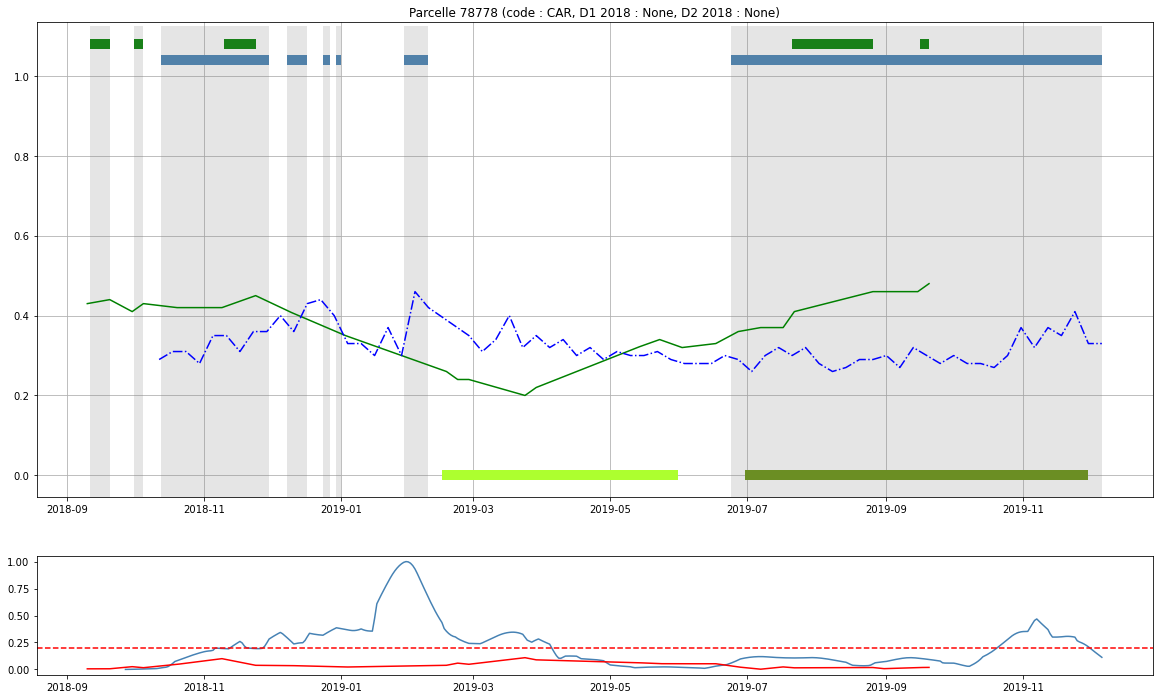

In [88]:
cover_coh = get_cover_intervals(df, 'cover_coh')
cover_coh_ia = get_cover_intervals(df, 'cover_coh_ia')
cover_ndvi = get_cover_intervals(df, 'cover_ndvi')

fig, axs = plt.subplots(2, figsize=(20, 12), gridspec_kw={'height_ratios': [4, 1]})

# Indicateurs
axs[0].plot(df['ndvi'], 'g-', label="NDVI")
axs[0].plot(df['coh'], 'b-.', label="Cohérence")

# Debogage
for iv in cover_coh:
    axs[0].hlines(1, iv.left, iv.right, color="blue", linewidth=10)
for iv in cover_coh_ia:
    axs[0].hlines(1.04, iv.left, iv.right, color="steelblue", linewidth=10)
for iv in cover_ndvi:
    axs[0].hlines(1.08, iv.left, iv.right, color="green", linewidth=10)

# Intervalles de couverture
for interval in cover_intervals:
    axs[0].hlines(0.5, interval.left, interval.right, color="gray", linewidth=500, alpha=0.2)

# Information phénologiques
axs[0].hlines(0, sowing_start, sowing_end, label="Semis", linewidth=10, color="greenyellow")
axs[0].hlines(0, harvest_start, harvest_end, label="Récolte", linewidth=10, color="olivedrab")

# Mise en forme
axs[0].set_title(f"Parcelle {id} (code : {code}, D1 2018 : {culture_d1_2018}, D2 2018 : {culture_d2_2018})")
axs[0].grid()
#plt.legend()

# Entropy
entropy_max = df['entropy'].max()
axs[1].plot(df['entropy'] / entropy_max, label="Dérivée cohérence", color="steelblue")
axs[1].axhline(entropy_threshold / entropy_max, color="steelblue", linestyle="--")
axs[1].plot(np.abs((-1.055*df['bsi']) + 0.467 - df['ndvi']), label="NDVI - NDVI interpolé", color="red")
axs[1].axhline(0.2, color="red", linestyle="--")